#

In [97]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyBboxPatch, Circle

import qutip
from qutip_qip.circuit import QubitCircuit
from qutip_qip.operations import Gate

In [98]:
WIRE_SEP = 0.7
LAYER_SEP = 0.6
PAD_LABEL = 0.3
GATE_HEIGHT = 0.2
GATE_WIDTH = 0.2
GATE_PAD = (LAYER_SEP - GATE_WIDTH)/2
FONT_SIZE =  10

In [99]:
def draw_wire(ax, n_wires):

    n_layers=2
    wires = [[(0, n_layers*LAYER_SEP) , (i*WIRE_SEP, i*WIRE_SEP) ] for i in range(n_wires)]

    for wire in wires:
        line = plt.Line2D(xdata=wire[0], ydata=wire[1], color='black', zorder=1)
        ax.add_line(line)


In [100]:
def extend_wire(ax, n_wires, old_layers, add_layers):
    
    wires = [[(old_layers * LAYER_SEP, (old_layers + add_layers) * LAYER_SEP), (i * WIRE_SEP, i * WIRE_SEP)] for i in range(n_wires)]

    for wire in wires:
        line = plt.Line2D(xdata=wire[0], ydata=wire[1], color='black', zorder=1)
        ax.add_line(line)

In [101]:
def add_labels(ax, n_wires, wire_labels=[]):

    if wire_labels == []:
        wire_labels = [f"$q_{{{i}}}$" for i in range(n_wires)]
        
    for i, label in enumerate(wire_labels):
        ax.text(-PAD_LABEL, i * WIRE_SEP, label, fontsize=FONT_SIZE, verticalalignment='center')

In [102]:
def draw_control_node(ax, layer, target):

    # make a circle patch
    node = Circle((layer * LAYER_SEP + LAYER_SEP / 2, target * WIRE_SEP), 0.05, facecolor='blue', zorder=2)
    ax.add_patch(node)

In [103]:
def draw_target_node(ax, layer, target):
    TARGET_RADIUS = 0.12
    
    # Draw the target node as a circle
    node = Circle((layer * LAYER_SEP + LAYER_SEP / 2, target * WIRE_SEP), TARGET_RADIUS, facecolor='blue', zorder=2)
    ax.add_patch(node)
    
    # Draw plus sign
    vertical = plt.Line2D((layer * LAYER_SEP + LAYER_SEP / 2, layer * LAYER_SEP + LAYER_SEP / 2),
                          (target * WIRE_SEP - TARGET_RADIUS/2, target * WIRE_SEP + TARGET_RADIUS/2),
                            linewidth=1.5, color='white', zorder=3)
    
    horizontal = plt.Line2D((layer * LAYER_SEP + LAYER_SEP / 2 - TARGET_RADIUS/2, layer * LAYER_SEP + LAYER_SEP / 2 + TARGET_RADIUS/2),
                            (target * WIRE_SEP, target * WIRE_SEP),
                            linewidth=1.5, color='white', zorder=3)
        
    ax.add_line(vertical)
    ax.add_line(horizontal)

In [104]:
# add SWAP GATE mark "X"" on the target qubit
def draw_swap_mark(ax, layer, wire):

    # Draw the diagonal lines to form an "X" 
    dia_left = plt.Line2D(
        [layer * LAYER_SEP + LAYER_SEP / 2 - GATE_WIDTH / 3, layer * LAYER_SEP + LAYER_SEP / 2 + GATE_WIDTH / 3],
        [wire * WIRE_SEP - GATE_HEIGHT / 2, wire * WIRE_SEP + GATE_HEIGHT / 2],
        color="blue", linewidth=1.5, zorder=3
    )
    dia_right = plt.Line2D(
        [layer * LAYER_SEP + LAYER_SEP / 2 + GATE_WIDTH / 3, layer * LAYER_SEP + LAYER_SEP / 2 - GATE_WIDTH / 3],
        [wire * WIRE_SEP - GATE_HEIGHT / 2, wire * WIRE_SEP + GATE_HEIGHT / 2],
        color="blue", linewidth=1.5, zorder=3
    )
        
    ax.add_line(dia_left)
    ax.add_line(dia_right)
    


In [105]:
def draw_bridge(ax, layer, wire1, wire2):

    bridge = plt.Line2D(
        [layer*LAYER_SEP + LAYER_SEP/2, layer*LAYER_SEP + LAYER_SEP/2],
        [wire1*WIRE_SEP, wire2*WIRE_SEP],
        color='blue', linewidth=1, zorder=2
    )

    ax.add_line(bridge)


In [106]:
def multiq_add_gate(ax, layer, gate):

    # check if gate is a qutip Gate
    if not isinstance(gate, Gate):
        print("Gate is not a qutip Gate")
        return
    
    # check if gate has multiple targets
    if gate.name == "CNOT":
        draw_control_node(ax, layer, gate.controls[0],)
        draw_target_node(ax, layer, gate.targets[0])
        draw_bridge(ax, layer, gate.targets[0], gate.controls[0])

    if gate.name == "SWAP":
        draw_swap_mark(ax, layer, gate.targets[0])
        draw_swap_mark(ax, layer, gate.targets[1])
        draw_bridge(ax, layer, gate.targets[0], gate.targets[1])

In [107]:
# adding gate, currently only works for qutip Gates
def add_gate(ax, layer, gate):
    
    if isinstance(gate, Gate):
        pass
        # print("Gate is a qutip Gate")
    else:
        pass
        # print("Gate is not a qutip Gate")

    
    gate_label = f"${gate.name}$"
    gate_wire = gate.targets[0]

    gate_patch = FancyBboxPatch(
        (layer * LAYER_SEP + GATE_PAD, gate_wire * WIRE_SEP - GATE_HEIGHT / 2), 
        GATE_WIDTH, 
        GATE_HEIGHT, 
        boxstyle="round4", 
        mutation_scale=0.3, 
        facecolor="aqua", 
        edgecolor="aqua",
        zorder=2
    ) 
    
    # gate_patch = Rectangle((layer*LAYER_SEP + GATE_PAD, gate_wire*WIRE_SEP - GATE_HEIGHT/2), GATE_WIDTH, GATE_HEIGHT, facecolor='aqua', zorder=2)
    ax.add_patch(gate_patch)

    # add gate label
    ax.text(layer*LAYER_SEP +  GATE_PAD + GATE_WIDTH/2, gate_wire*WIRE_SEP, gate_label, fontsize=FONT_SIZE, verticalalignment='center', horizontalalignment='center')

    

In [108]:
def canvas_plot(qc, height, width):
    
    fig, ax = plt.subplots(figsize=(width, height))

    nwire = qc.N
    display_layers = 2
    draw_wire(ax, nwire) # generalize TODO 
    add_labels(ax, nwire)

    # make a dict with wire_labels as keys and zero values
    gate_maintain = {f"q{i}": 0 for i in range(nwire)}

    for gate in qc.gates:

        if len(gate.targets) == 1 and gate.controls == None:
            add_gate(ax, gate_maintain[f"q{gate.targets[0]}"], gate)
            gate_maintain[f"q{gate.targets[0]}"] += 1
        else:
            multiq_add_gate(ax, gate_maintain[f"q{gate.targets[0]}"], gate)
            # update all values to multiqubot target
            temp = gate_maintain[f"q{gate.targets[0]}"] + 1
            gate_maintain = {key:temp for key in gate_maintain.keys()}
            
        if max(gate_maintain.values()) >= display_layers:
            extend_wire(ax, nwire, display_layers, add_layers=1)

            display_layers += 1
        
    
    ax.set_ylim(-WIRE_SEP, nwire*WIRE_SEP)
    ax.set_xlim(-LAYER_SEP, (display_layers + 1)*LAYER_SEP)
    ax.set_aspect('equal')
    ax.axis('off')
    fig.set_dpi(200)


In [109]:
def calsize(qc):

    n_wires = qc.N  
    height = n_wires * 0.393701 * WIRE_SEP * 3
    width = 10

    return height, width

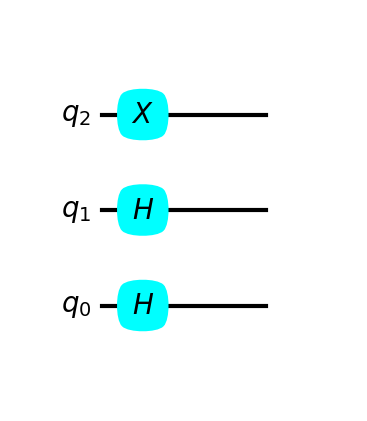

In [110]:
qc = QubitCircuit(3)
qc.add_gate("H", targets=[0])
qc.add_gate("H", targets=[1])
qc.add_gate("X", targets=[2])
qc.gates[0].targets, qc.png

h, w = calsize(qc)
canvas_plot(qc, h, w)

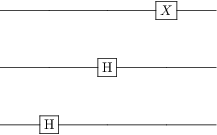

In [111]:
qc

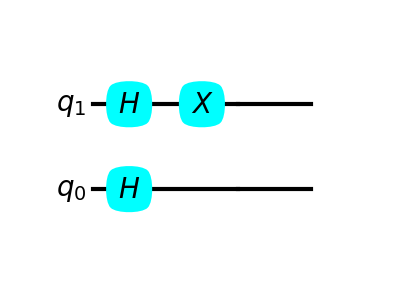

In [112]:
qc = QubitCircuit(2)
qc.add_gate("H", targets=[0])
qc.add_gate("H", targets=[1])
qc.add_gate("X", targets=[1])
qc.gates[0].targets, qc.png

h, w = calsize(qc)
canvas_plot(qc, h, w)

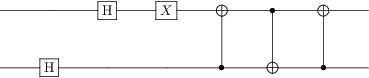

In [113]:
qc = QubitCircuit(2)
qc.add_gate("H", targets=[0])
qc.add_gate("H", targets=[1])
qc.add_gate("X", targets=[1])
qc.add_gate("CNOT", controls=[0], targets=[1])
qc.add_gate("CNOT", controls=[1], targets=[0])
qc.add_gate("CNOT", controls=[0], targets=[1])
qc

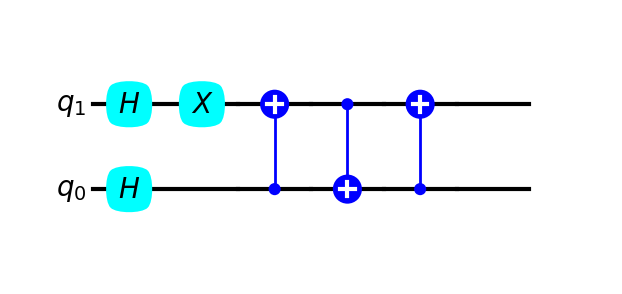

In [114]:
h, w = calsize(qc)
canvas_plot(qc, h, w)

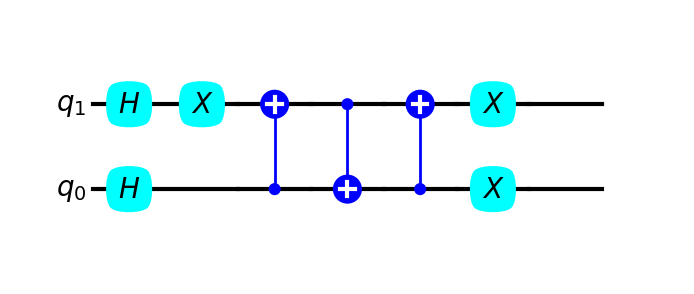

In [115]:
qc.add_1q_gate("X")
canvas_plot(qc, h, w)

In [116]:
qc = QubitCircuit(3)
qc.add_gate("H", targets=[0])
qc.add_gate("CNOT", targets=[1], controls=[2])
qc.add_gate("H", targets=[1])
qc.add_gate("X", targets=[1])
qc.add_gate("CNOT", controls=[0], targets=[1])
qc.add_gate("CNOT", controls=[1], targets=[0])
qc.add_gate("CNOT", controls=[0], targets=[2])

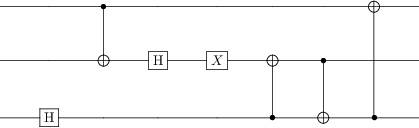

In [117]:
qc

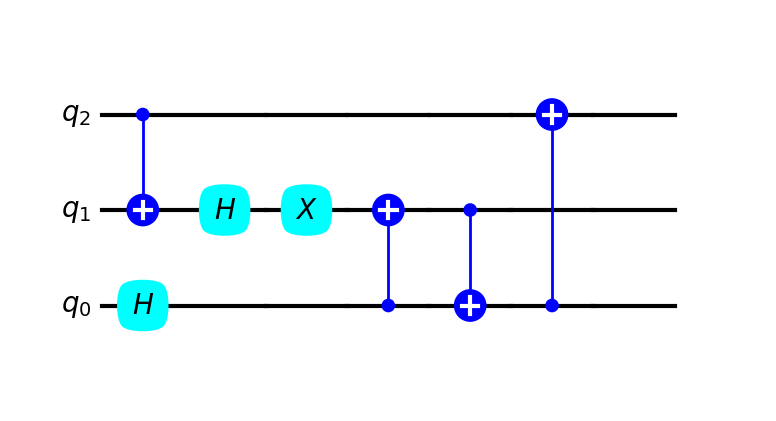

In [118]:
h, w = calsize(qc)
canvas_plot(qc, h, w)

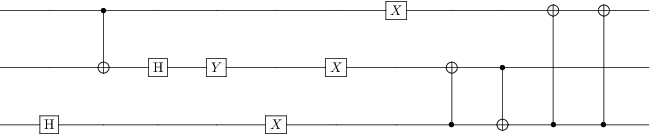

In [119]:
qc = QubitCircuit(3)
qc.add_gate("H", targets=[0])
qc.add_gate("CNOT", targets=[1], controls=[2])
qc.add_gate("H", targets=[1])
qc.add_gate("Y", targets=[1])
qc.add_1q_gate("X")
qc.add_gate("CNOT", controls=[0], targets=[1])
qc.add_gate("CNOT", controls=[1], targets=[0])
qc.add_gate("CNOT", controls=[0], targets=[2])
qc.add_gate("CNOT", controls=[0], targets=[2])
qc

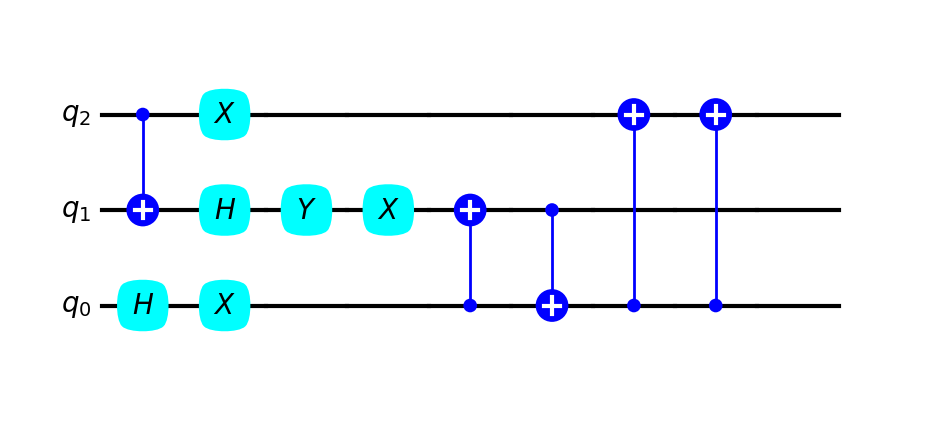

In [120]:
h, w = calsize(qc)
canvas_plot(qc, h, w)